![lop](../../images/logo_diive1_128px.png)

<span style='background:#FFF8E1; font-size:40px; display:block; border-left:40px solid #FFECB3; padding-left:40px;'>
<b>
    Flux Processing Chain
</b>
</span>

---
**Notebook version**: `3` (22 Aug 2023)  
Example notebook for the flux processing chain using the time series processing library `diive`.  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  


</br>

---

# **Background**

- This notebook demonstrates part of the flux post-processing used for fluxes from Swiss FluxNet research stations
- For a description of the different flux levels, see [Flux Processing Chain](https://www.swissfluxnet.ethz.ch/index.php/data/ecosystem-fluxes/flux-processing-chain/)
- Flux calculations (Level-1) were done in a previous step
- This notebook uses the calculated fluxes (Level-1) and applies several post-processing steps:
    - Quality flag extension (Level-2)
    - Storage correction (Level-3.1)
    - Outlier removel (Level-3.2)
- Other flux levels are currently not produced in this example:
    - Gap-filling (Level-4.1)
    - NEE Partitioning (Level-4.2)

</br>

---

# **Setup**

## User settings
`FLUXVAR` is the name of the flux variable in the data files. In the EddyPro `_fluxnet_` output files, the flux variables we primarily use are:
  - `FC` ... CO2 flux, becomes `NEE` after storage correction (Level-3.1)
  - `LE` ... Latent heat flux (water)
  - `H` ... Sensible heat flux
  
There are more flux variables in the output file, but we rarely need them:
  - `FH2O` ... H2O flux, very important but it is the same as `ET` and `LE` but with different units
  - `ET` ... Evapotranspiration, very important but it is the same as `FH2O` and `LE` but with different units. We can easily calculte `ET` later from `LE`, e.g. in `ReddyProc`.
  - `TAU` ... Momentum flux, a measure of the turbulent transfer of momentum between the land surface and the atmosphere

In [1]:
FLUXVAR = "FC"  # Name of the flux variable: FC (CO2 flux), LE (latent heat, water) of H (sensible heat)
FOLDERS = [r"F:\TMP\fru"]  # Folders where data files are located, in case you want to load data from these files
SITE_LAT = 46.815333  # Latitude of site
SITE_LON = 9.855972  # Longitude of site

## Imports
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [2]:
import os
import pkg_resources
import pandas as pd
from datetime import datetime
from pathlib import Path
from diive.core.io.filereader import MultiDataFileReader, search_files
from diive.core.io.files import save_parquet, load_parquet
from diive.core.times.times import TimestampSanitizer
from diive.pkgs.fluxprocessingchain.level2_qualityflags import FluxQualityFlagsLevel2EddyPro
from diive.pkgs.fluxprocessingchain.level31_storagecorrection import FluxStorageCorrectionSinglePointEddyPro
from diive.pkgs.outlierdetection.stepwiseoutlierdetection import StepwiseOutlierDetection
from diive.pkgs.qaqc.qcf import FlagQCF
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats

dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"This page was last modified on: {dt_string}")
version_diive = pkg_resources.get_distribution("diive").version
print(f"diive version: v{version_diive}")

Loading BokehJS ...

C:\Users\nopan\AppData\Local\pypoetry\Cache\virtualenvs\diive-wQ6jAUAf-py3.9\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


This page was last modified on: 2023-08-22 01:05:49
diive version: v0.57.0


### Show docstring for `FluxQualityFlagsLevel2EddyPro`

In [3]:
print(FluxQualityFlagsLevel2EddyPro.__name__)
print(FluxQualityFlagsLevel2EddyPro.__doc__)

FluxQualityFlagsLevel2EddyPro

    Create QCF (quality-control flag) for selected flags, calculated
    from EddyPro's _fluxnet_ output files
    


### Show docstring for `FluxStorageCorrectionSinglePointEddyPro`

In [4]:
print(FluxStorageCorrectionSinglePointEddyPro.__name__)
print(FluxStorageCorrectionSinglePointEddyPro.__doc__)

FluxStorageCorrectionSinglePointEddyPro

    Estimation of storage fluxes (gases, sensible heat, latent heat) from concentrations
    (1-point profile) as calculated by EddyPro
    


### Show docstring for `StepwiseOutlierDetection`

In [5]:
print(StepwiseOutlierDetection.__name__)
print(StepwiseOutlierDetection.__doc__)

StepwiseOutlierDetection

    Step-wise outlier detection in time series data

    The class is optimized to work in Jupyter notebooks.

    Quality flags that can be directly created via this class:
    - `.flag_missingvals_test()`: Generate flag that indicates missing records in data
    - `.flag_outliers_abslim_test()`: Generate flag that indicates if values in data are outside the specified range
    - `.flag_outliers_abslim_dtnt_test()`: Generate flag that indicates if daytime and nighttime values in data are
        outside their respectively specified ranges
    - `.flag_outliers_increments_zcore_test()`: Identify outliers based on the z-score of increments
    - `.flag_outliers_localsd_test()`: Identify outliers based on the local standard deviation
    - `.flag_manualremoval_test()`: Remove data points for range, time or point-by-point
    - `.flag_outliers_stl_riqrz_test()`: Identify outliers based on seasonal-trend decomposition and z-score
        calculations, taking the i

</br>

# **Load data** (2 options)

## Option 1: Load data from single or multiple output files
- Used to read data from the EddyPro _fluxnet_ output files

### Search files

In [6]:
filepaths = search_files(FOLDERS, "*.csv")  # Search all CSV files in folder and subfolders and store filepaths in list
filepaths = [fp for fp in filepaths if "eddypro_" in fp.stem and "_fluxnet_" in fp.stem and fp.stem.endswith("_adv")]  # Filter list and keep only EddyPro _fluxnet_ output files
filepaths

[WindowsPath('F:/TMP/fru/eddypro_CH-FRU_FR-20230720-102609_fluxnet_2023-07-20T113156_adv.csv'),
 WindowsPath('F:/TMP/fru/eddypro_CH-FRU_FR-20230821-002700_fluxnet_2023-08-21T005407_adv.csv'),
 WindowsPath('F:/TMP/fru/eddypro_CH-FRU_FR-20230821-090003_fluxnet_2023-08-21T092339_adv.csv')]

### Read Files

In [7]:
data = MultiDataFileReader(filetype='EDDYPRO_FLUXNET_30MIN', filepaths=filepaths)
df_orig = data.data_df.copy()

Reading file eddypro_CH-FRU_FR-20230720-102609_fluxnet_2023-07-20T113156_adv.csv ...
Reading file eddypro_CH-FRU_FR-20230821-002700_fluxnet_2023-08-21T005407_adv.csv ...
Reading file eddypro_CH-FRU_FR-20230821-090003_fluxnet_2023-08-21T092339_adv.csv ...


</br>

### Option 2: Load data from `parquet` file
- Used to continue a previous session where another flux variable was already post-processed
- For example, if you have already post-processed CO2 flux and now want to post-process H2O flux
- Also detects time resolution of time series, this info was lost when saving to the parquet file

In [ ]:
df_orig = load_parquet(filepath='df_level32_qcf.parquet')

</br>

## Check data

In [8]:
df_orig

,AIR_MV,AIR_DENSITY,AIR_RHO_CP,AIR_CP,AOA_METHOD,AXES_ROTATION_METHOD,BOWEN,BURBA_METHOD,BADM_LOCATION_LAT,BADM_LOCATION_LONG,BADM_LOCATION_ELEV,BADM_HEIGHTC,BADM_INST_SAMPLING_INT,BADM_INST_AVERAGING_INT,BADM_INST_MODEL_SA,...,W_T_SONIC_COV_IBROM_N0004,W_NUM_SPIKES,WD_FILTER_NREX,W_SPIKE_NREX,W_ABSLIM_NREX,W_VM97_TEST,W_LGD,W_KID,W_ZCD,W_ITC,W_ITC_TEST,WBOOST_APPLIED,WPL_APPLIED,ZL,ZL_UNCORR
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-01 01:15:00,0.027066,1.06955,1081.03,1010.74,0.0,1.0,-3.828950,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,NaN,9.0,0.0,13.0,0.0,800001101.0,0.0,14.88010,177.0,51.0,4.0,0.0,1.0,0.044801,0.043876
2023-01-01 01:45:00,0.027040,1.07053,1082.14,1010.85,0.0,1.0,-2.653010,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,NaN,3.0,0.0,5.0,0.0,800000111.0,0.0,12.74580,866.0,34.0,3.0,0.0,1.0,0.119482,0.116276
2023-01-01 02:15:00,0.026982,1.07284,1084.65,1011.00,0.0,1.0,5.400880,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,NaN,4.0,0.0,7.0,0.0,800000111.0,0.0,15.86960,396.0,53.0,4.0,0.0,1.0,0.084251,0.084413
2023-01-01 02:45:00,0.027030,1.07097,1082.11,1010.40,0.0,1.0,0.046930,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,NaN,10.0,0.0,19.0,0.0,800001111.0,0.0,21.29290,613.0,39.0,3.0,0.0,1.0,0.004448,0.009392
2023-01-01 03:15:00,0.026968,1.07340,1085.13,1010.93,0.0,1.0,2.211990,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,NaN,2.0,0.0,2.0,0.0,800000111.0,0.0,16.11830,447.0,5.0,1.0,0.0,1.0,0.428724,0.431234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-20 16:45:00,0.028201,1.02609,1041.27,1014.79,0.0,1.0,0.156240,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.012398,0.0,0.0,0.0,0.0,800000001.0,0.0,10.88530,282.0,11.0,1.0,0.0,1.0,-0.185465,-0.253989
2023-08-20 17:15:00,0.028188,1.02654,1041.75,1014.82,0.0,1.0,-0.218496,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.014559,1.0,0.0,1.0,0.0,800000011.0,0.0,12.55340,1342.0,54.0,4.0,0.0,1.0,-0.010205,-0.007789
2023-08-20 17:45:00,0.028170,1.02707,1043.59,1016.08,0.0,1.0,-0.169326,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,-0.003599,8.0,0.0,15.0,0.0,800000111.0,0.0,8.68114,230.0,20.0,2.0,0.0,1.0,0.372024,0.277043


In [9]:
df_orig.describe()

,AIR_MV,AIR_DENSITY,AIR_RHO_CP,AIR_CP,AOA_METHOD,AXES_ROTATION_METHOD,BOWEN,BURBA_METHOD,BADM_LOCATION_LAT,BADM_LOCATION_LONG,BADM_LOCATION_ELEV,BADM_HEIGHTC,BADM_INST_SAMPLING_INT,BADM_INST_AVERAGING_INT,BADM_INST_MODEL_SA,...,W_T_SONIC_COV_IBROM_N0004,W_NUM_SPIKES,WD_FILTER_NREX,W_SPIKE_NREX,W_ABSLIM_NREX,W_VM97_TEST,W_LGD,W_KID,W_ZCD,W_ITC,W_ITC_TEST,WBOOST_APPLIED,WPL_APPLIED,ZL,ZL_UNCORR
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.0,10982.0,9695.000000,10982.0,1.098200e+04,10982.00000,10982.0,10982.0,10982.0,10982.0,0.0,...,228.000000,10982.000000,10982.0,10982.000000,10982.0,1.098200e+04,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.0,10982.0,10982.000000,10982.000000
mean,0.026634,1.087599,1098.694882,1010.263208,0.0,1.0,0.304540,0.0,4.711580e+01,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.007331,7.712074,0.0,10.544618,0.0,8.000628e+08,0.027144,11.006279,545.336369,21.110089,1.855127,0.0,1.0,-0.034134,-0.042513
std,0.000654,0.027011,24.719921,3.219439,0.0,0.0,36.817133,0.0,7.105751e-15,0.00000,0.0,0.0,0.0,0.0,NaN,...,0.011227,16.847532,0.0,18.072831,0.0,2.617809e+05,0.434336,19.139077,1122.991549,19.012623,1.005789,0.0,0.0,3.433732,4.505165
min,0.024605,1.020410,1035.040000,983.575000,0.0,1.0,-634.581000,0.0,4.711580e+01,8.53778,982.0,0.4,20.0,30.0,NaN,...,-0.041717,0.000000,0.0,0.000000,0.0,8.000000e+08,0.000000,3.027330,0.000000,0.000000,1.000000,0.0,1.0,-211.341000,-211.588000
25%,0.026139,1.068010,1081.250000,1008.180000,0.0,1.0,-0.709795,0.0,4.711580e+01,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.000324,1.000000,0.0,2.000000,0.0,8.000000e+08,0.000000,7.130797,16.000000,7.000000,1.000000,0.0,1.0,-0.120621,-0.131302
50%,0.026630,1.087160,1097.780000,1010.060000,0.0,1.0,0.071362,0.0,4.711580e+01,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.004761,4.000000,0.0,6.000000,0.0,8.000000e+08,0.000000,8.676400,101.000000,16.000000,2.000000,0.0,1.0,-0.006421,-0.007577
75%,0.027098,1.107770,1116.585000,1012.740000,0.0,1.0,0.565269,0.0,4.711580e+01,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.012191,8.000000,0.0,12.000000,0.0,8.000001e+08,0.000000,10.978725,557.000000,31.000000,3.000000,0.0,1.0,0.064701,0.059519
max,0.028356,1.177160,1183.130000,1019.290000,0.0,1.0,2265.540000,0.0,4.711580e+01,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.076953,531.000000,0.0,539.000000,0.0,8.110111e+08,28.700000,1115.920000,14425.000000,255.000000,7.000000,0.0,1.0,185.790000,356.062000


In [10]:
sstats(df_orig[FLUXVAR])

,FC
STARTDATE,2023-01-01 01:15
ENDDATE,2023-08-20 18:45
PERIOD,231 days 17:30:00
NOV,9917
MISSING,1207
MISSING_PERC,10.850414
MEAN,-1.902687
SD,30.900182
VAR,954.821241
SD/MEAN,-16.240285


In [13]:
TimeSeries(series=df_orig[FLUXVAR]).plot_interactive()

</br>

</br>

---

# **Level-2: Quality flag extension**

> Extract additional quality information from the EddyPro `_fluxnet_` output file and store it in newly added quality flags.



Note that the USTAR filtering is not part of the Level-2 calculations.

</br>

## Inititate calculations

In [14]:
fluxqc = FluxQualityFlagsLevel2EddyPro(fluxcol=FLUXVAR, df=df_orig, levelid='L2')

Detected base variable CO2 for FC.


</br>

</br>

## Flag: **Missing values** test
- Flag calculated here from missing flux values in the EddyPro output file

In [15]:
fluxqc.missing_vals_test()

Generating new flag variable FLAG_L2_FC_MISSING_TEST, newly calculated from output variable FC,with flag 0 (good values) where FC is available, flag 2 (bad values) where FC is missing ...


</br>

</br>

## Flag: **SSITC** tests
- Flag calculated in EddyPro
- Combination of the two partial tests *steady state test* and *developed turbulent conditions test*
- This notebook expects the SSITC flag to follow the flagging policy according to Mauder and Foken 2004: `0` for best quality fluxes, `1` for fluxes suitable for general analysis such as annual
budgets (although this is debatable) and `2` for fluxes that should be discarded from the dataset

In [16]:
fluxqc.ssitc_test()

Generating new flag variable FLAG_L2_FC_SSITC_TEST, values taken from output variable FC_SSITC_TEST ...


</br>

</br>

## Flag: **Completeness** test
- Flag calculated here from the gas number of records percentage in EddyPro output file
- Checks gas number of records available for each averaging Interval

In [17]:
fluxqc.gas_completeness_test()

Generating new flag variable FLAG_L2_FC_COMPLETENESS_TEST, newly calculated from output variable CO2_NR_PERC, with flag 0 (good values) where CO2_NR_PERC >= 0.99, flag 1 (ok values) where CO2_NR_PERC >= 0.97 and < 0.99, flag 2 (bad values) < 0.97...


</br>

</br>

## Flag: **Spectral correction factor** test
- Flag calculated here from the gas `scf` variable in EddyPro output file

In [18]:
fluxqc.spectral_correction_factor_test()

Generating new flag variable FLAG_L2_FC_SCF_TEST, newly calculated from output variable FC_SCF, withflag 0 (good values) where FC_SCF < 2, flag 1 (ok values) where FC_SCF >= 2 and < 4, flag 2 (bad values) where FC_SCF >= 4...


</br>

</br>

## Flag: **Signal strength / AGC** / window dirtiness test (if available)
- Flag calculated here from the signal strength / AGC variable for the gas analyzer in EddyPro output file

<div class="alert alert-block alert-danger">
    <b>Do not use for H (sensible heat flux).</b> This test is only relevant for fluxes where the concentration was measured by a gas analyzer, e.g. FC, FH2O, LE, ET, N2O, CH4, etc ... 
</div>

In [19]:
SIGNAL_STRENGTH_COL = 'CUSTOM_AGC_MEAN'  # Name of the column storing the signal strength, typically 'CUSTOM_AGC_MEAN' for LI-7500, 'CUSTOM_SIGNAL_STRENGTH_IRGA72_MEAN' for LI-7200, or something similar
SIGNAL_STRENGTH_THRESHOLD = 90  # Signal strength threshold, flux values where threshold is exceeded are flagged as rejected
SIGNAL_STRENGTH_METHOD = 'discard above'  # 'discard above' flags fluxes where signal strength > threshold, 'discard below' where signal strength < threshold

In [20]:
TimeSeries(series=df_orig[SIGNAL_STRENGTH_COL]).plot_interactive()

In [21]:
fluxqc.signal_strength_test(signal_strength_col=SIGNAL_STRENGTH_COL,
                            method=SIGNAL_STRENGTH_METHOD, 
                            threshold=SIGNAL_STRENGTH_THRESHOLD)

Generating new flag variable FLAG_L2_FC_SIGNAL_STRENGTH_TEST, newly calculated from output variable CUSTOM_AGC_MEAN, with flag 0 (good values) where CUSTOM_AGC_MEAN <= 90, flag 2 (bad values) where CUSTOM_AGC_MEAN > 90 ...


</br>

</br>

## Flags: **Raw data screening** tests
- Flags were calculated in EddyPro

In [22]:
fluxqc.raw_data_screening_vm97_tests(spikes=True,
                                     amplitude=True,
                                     dropout=True,
                                     abslim=False,
                                     skewkurt_hf=False,
                                     skewkurt_sf=False,
                                     discont_hf=False,
                                     discont_sf=False)

Generating new flag variable FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST, values taken from output variable CO2_VM97_TEST from position 1, based on CO2, with flag 0 (good values) where test passed, flag 2 (bad values) where test failed (for hard flags) or flag 1 (ok values) where test failed (for soft flags) ...
Generating new flag variable FLAG_L2_FC_CO2_VM97_AMPLITUDE_RESOLUTION_HF_TEST, values taken from output variable CO2_VM97_TEST from position 2, based on CO2, with flag 0 (good values) where test passed, flag 2 (bad values) where test failed (for hard flags) or flag 1 (ok values) where test failed (for soft flags) ...
Generating new flag variable FLAG_L2_FC_CO2_VM97_DROPOUT_TEST, values taken from output variable CO2_VM97_TEST from position 3, based on CO2, with flag 0 (good values) where test passed, flag 2 (bad values) where test failed (for hard flags) or flag 1 (ok values) where test failed (for soft flags) ...


</br>

</br>

## Flag: **Angle-of-attack** test (optional)
- Flag was calculated in EddyPro

In [23]:
fluxqc.angle_of_attack_test()

Generating new flag variable FLAG_L2_FC_VM97_AOA_HF_TEST, values taken from output variable VM97_AOA_HF, with flag 0 (good values) where test passed, flag 2 (bad values) where test failed ...


</br>

</br>

## Add flags to dataset

In [24]:
# print(fluxqc.fluxflags)
df_level2 = fluxqc.get()

++Adding new column FLAG_L2_FC_MISSING_TEST (Level-2 quality flag) to main data ...
++Adding new column FLAG_L2_FC_SSITC_TEST (Level-2 quality flag) to main data ...
++Adding new column FLAG_L2_FC_COMPLETENESS_TEST (Level-2 quality flag) to main data ...
++Adding new column FLAG_L2_FC_SCF_TEST (Level-2 quality flag) to main data ...
++Adding new column FLAG_L2_FC_SIGNAL_STRENGTH_TEST (Level-2 quality flag) to main data ...
++Adding new column FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST (Level-2 quality flag) to main data ...
++Adding new column FLAG_L2_FC_CO2_VM97_AMPLITUDE_RESOLUTION_HF_TEST (Level-2 quality flag) to main data ...
++Adding new column FLAG_L2_FC_CO2_VM97_DROPOUT_TEST (Level-2 quality flag) to main data ...
++Adding new column FLAG_L2_FC_VM97_AOA_HF_TEST (Level-2 quality flag) to main data ...


</br>

</br>

## Available `Level-2` variables
- This shows all available Level-2 variables, also the ones created previously for other fluxes

In [25]:
[x for x in df_level2.columns if 'L2' in x]

['FLAG_L2_FC_MISSING_TEST',
 'FLAG_L2_FC_SSITC_TEST',
 'FLAG_L2_FC_COMPLETENESS_TEST',
 'FLAG_L2_FC_SCF_TEST',
 'FLAG_L2_FC_SIGNAL_STRENGTH_TEST',
 'FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST',
 'FLAG_L2_FC_CO2_VM97_AMPLITUDE_RESOLUTION_HF_TEST',
 'FLAG_L2_FC_CO2_VM97_DROPOUT_TEST',
 'FLAG_L2_FC_VM97_AOA_HF_TEST']

</br>

</br>

---

# **Level-3.1: Storage correction**

(description here)

## Inititate calculations

In [26]:
s = FluxStorageCorrectionSinglePointEddyPro(df=df_level2, fluxcol=FLUXVAR)

Detected base variable CO2 for FC.
Detected storage variable SC_SINGLE for FC.


</br>

## Calculate storage correction
- The flux storage term (single point) is added to the flux
- For some records, the storage term can be missing. In such cases, missing terms are gap-filled using random forest
- Without gap-filling the storage term, we can lose an additional e.g. 2-3% of flux data

In [27]:
s.storage_correction()

Calculating storage-corrected flux NEE_L3.1 from flux FC and storage term SC_SINGLE ...
(!) No step-lagged variants created because data comprises only one single column: Index(['SC_SINGLE'], dtype='object').
Added timestamp as columns: ['.YEAR', '.DOY', '.WEEK', '.MONTH', '.HOUR']
Assigning years for gap-filling ...
Gap-filling for year 2023 is based on data from years [2023].

[BUILDING MODEL]    Based on data from years [2023] ==============================
[BUILDING MODEL]    Target column:  SC_SINGLE  (9628 values)
[BUILDING MODEL]    Number of features used in model:  5
[BUILDING MODEL]    Names of features used in model:  ['.YEAR', '.DOY', '.WEEK', '.MONTH', '.HOUR']
[BUILDING MODEL]    Model data first timestamp:  2023-01-01T01:45:00.000000000
[BUILDING MODEL]    Model data last timestamp:  2023-08-20T18:45:00.000000000
[BUILDING MODEL]    Model parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nod

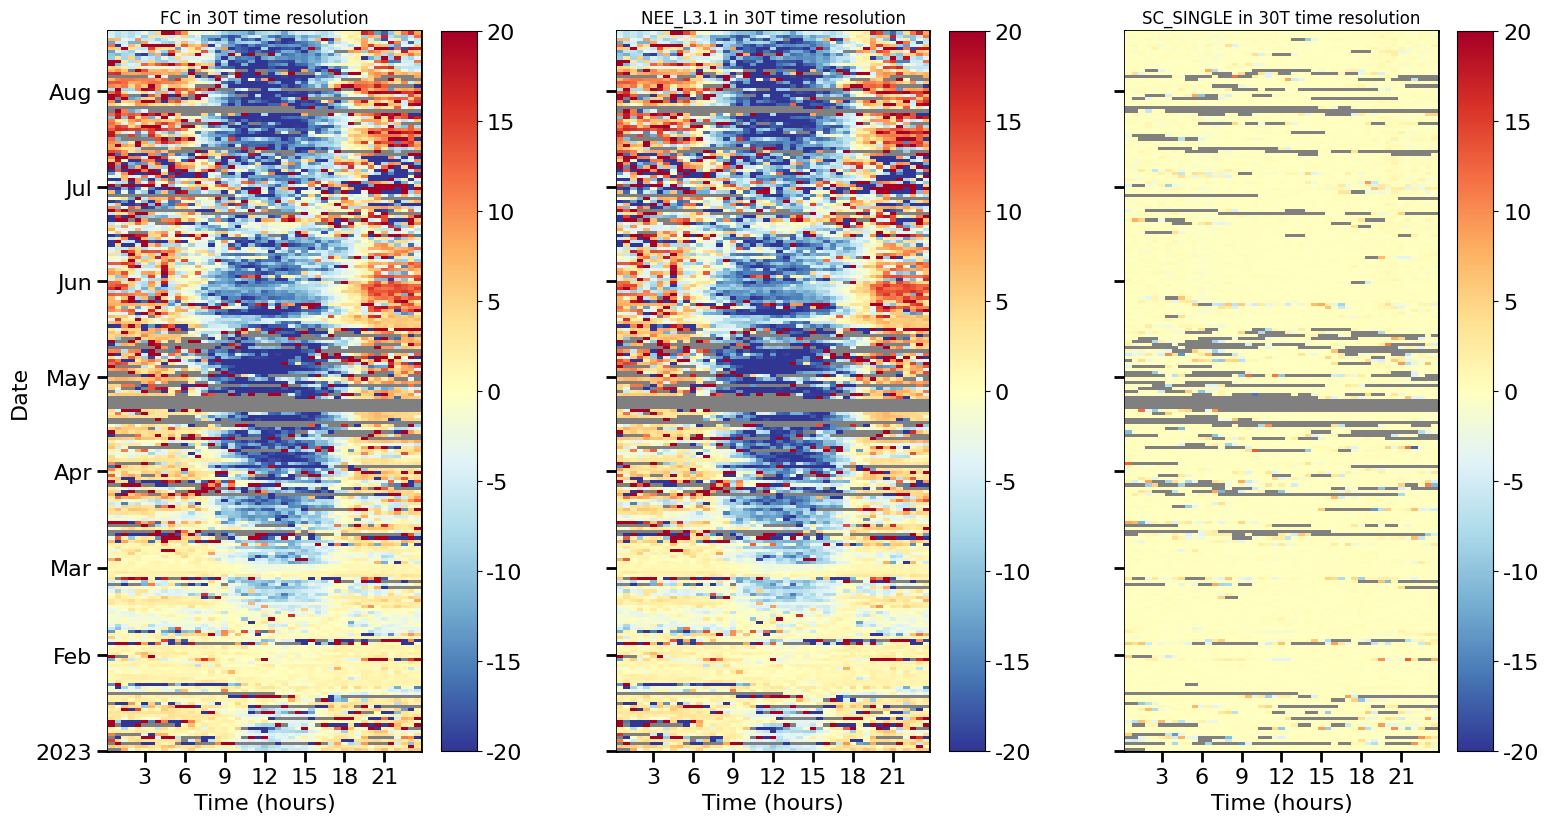

In [28]:
s.showplot(maxflux=20)

In [29]:
s.report()


REPORT: STORAGE CORRECTION FOR FC
Swiss FluxNet processing chain, L3.1: Storage Correction

The gap-filled storage term SC_SINGLE_gfRF_L3.1 was added to flux FC.
The storage-corrected flux was stored as NEE_L3.1.

The flux was available for 9917 records (FC).
Originally, the non-gapfilled storage term was available for 9628 records (SC_SINGLE).
After gap-filling the storage term, it was available for 11124 records (SC_SINGLE_gfRF_L3.1).
The non-gapfilled storage term (SC_SINGLE) was used for 9628 records in the storage-corrected flux (NEE_L3.1).
The gapfilled storage term (SC_SINGLE_gfRF_L3.1) was used for 289 records in the storage-corrected flux (NEE_L3.1).

In the storage-corrected flux NEE_L3.1 with 9917 records, 
  - 97.1% of used storage terms come from originally calculated data (SC_SINGLE)
  - 2.9% of used storage terms come from gap-filled data (SC_SINGLE_gfRF_L3.1)


</br>

## Add results to dataset
- Adds the storage-corrected flux and the gap-filled storage term time series to the dataset

In [30]:
# print(s.storage)
df_level31 = s.get()

++Adding new column NEE_L3.1 (L3.1 quality flag) to main data ...
++Adding new column SC_SINGLE_gfRF_L3.1 (L3.1 quality flag) to main data ...


In [31]:
df_level31

,AIR_MV,AIR_DENSITY,AIR_RHO_CP,AIR_CP,AOA_METHOD,AXES_ROTATION_METHOD,BOWEN,BURBA_METHOD,BADM_LOCATION_LAT,BADM_LOCATION_LONG,BADM_LOCATION_ELEV,BADM_HEIGHTC,BADM_INST_SAMPLING_INT,BADM_INST_AVERAGING_INT,BADM_INST_MODEL_SA,...,WBOOST_APPLIED,WPL_APPLIED,ZL,ZL_UNCORR,FLAG_L2_FC_MISSING_TEST,FLAG_L2_FC_SSITC_TEST,FLAG_L2_FC_COMPLETENESS_TEST,FLAG_L2_FC_SCF_TEST,FLAG_L2_FC_SIGNAL_STRENGTH_TEST,FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST,FLAG_L2_FC_CO2_VM97_AMPLITUDE_RESOLUTION_HF_TEST,FLAG_L2_FC_CO2_VM97_DROPOUT_TEST,FLAG_L2_FC_VM97_AOA_HF_TEST,NEE_L3.1,SC_SINGLE_gfRF_L3.1
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-01 01:15:00,0.027066,1.06955,1081.03,1010.74,0.0,1.0,-3.828950,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.0,1.0,0.044801,0.043876,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.990170,-0.051080
2023-01-01 01:45:00,0.027040,1.07053,1082.14,1010.85,0.0,1.0,-2.653010,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.0,1.0,0.119482,0.116276,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.076858,0.064472
2023-01-01 02:15:00,0.026982,1.07284,1084.65,1011.00,0.0,1.0,5.400880,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.0,1.0,0.084251,0.084413,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.619622,0.048761
2023-01-01 02:45:00,0.027030,1.07097,1082.11,1010.40,0.0,1.0,0.046930,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.0,1.0,0.004448,0.009392,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.851635,-0.008626
2023-01-01 03:15:00,0.026968,1.07340,1085.13,1010.93,0.0,1.0,2.211990,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.0,1.0,0.428724,0.431234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.689481,0.058891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-20 16:45:00,0.028201,1.02609,1041.27,1014.79,0.0,1.0,0.156240,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.0,1.0,-0.185465,-0.253989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.752027,-0.004197
2023-08-20 17:15:00,0.028188,1.02654,1041.75,1014.82,0.0,1.0,-0.218496,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.0,1.0,-0.010205,-0.007789,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-19.642896,-0.048196
2023-08-20 17:45:00,0.028170,1.02707,1043.59,1016.08,0.0,1.0,-0.169326,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.0,1.0,0.372024,0.277043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.776301,0.273919


</br>

## Available `Level-3.1` variables before preliminary QCF

In [32]:
_vars = [print(x) for x in df_level31.columns if 'L3.1' in x]
if FLUXVAR == 'FC':
    FLUXVAR31 = f"NEE_L3.1"
else:
    FLUXVAR31 = f"{FLUXVAR}_L3.1"  # Storage-corrected flux after Level-3.1
print(f"\nName of the storage-corrected flux variable after Level-3.1:  {FLUXVAR31}")

NEE_L3.1
SC_SINGLE_gfRF_L3.1

Name of the storage-corrected flux variable after Level-3.1:  NEE_L3.1


</br>

## Generate `QCF`, needed for Level-3.2
- `QCF` is the `quality control flag` that combines the quality tests so far into one single `QCF` flag (0-1-2)

In [33]:
qcf = FlagQCF(series=df_level31[FLUXVAR31], df=df_level31, levelid='L3.1', swinpot=df_level31['SW_IN_POT'], nighttime_threshold=50)
qcf.calculate(daytime_accept_qcf_below=2, nighttimetime_accept_qcf_below=2)
df_level31 = qcf.get()

++Adding new column SUM_L3.1_NEE_L3.1_HARDFLAGS to main data ...
++Adding new column SUM_L3.1_NEE_L3.1_SOFTFLAGS to main data ...
++Adding new column SUM_L3.1_NEE_L3.1_FLAGS to main data ...
++Adding new column FLAG_L3.1_NEE_L3.1_QCF to main data ...
++Adding new column NEE_L3.1_L3.1_QCF to main data ...


In [34]:
qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable NEE_L3.1.

Number of NEE_L3.1 records before QC: 9917
+++ FLAG_L2_FC_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 9917 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FC_SSITC_TEST rejected 725 values (+7.31%)      TOTALS: flag 0: 5299 (53.43%) / flag 1: 3893 (39.26%) / flag 2: 725 (7.31%)
+++ FLAG_L2_FC_COMPLETENESS_TEST rejected 24 values (+0.24%)      TOTALS: flag 0: 5283 (53.27%) / flag 1: 3885 (39.18%) / flag 2: 749 (7.55%)
+++ FLAG_L2_FC_SCF_TEST rejected 40 values (+0.40%)      TOTALS: flag 0: 5186 (52.29%) / flag 1: 3942 (39.75%) / flag 2: 789 (7.96%)
+++ FLAG_L2_FC_SIGNAL_STRENGTH_TEST rejected 254 values (+2.56%)      TOTALS: flag 0: 5113 (51.56%) / flag 1: 3761 (37.92%) / flag 2: 1043 (10.52%)
+++ FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST rejected 95 values (+0.96%)      TOTALS: flag 0: 5057 (50.99%) / flag 1: 372

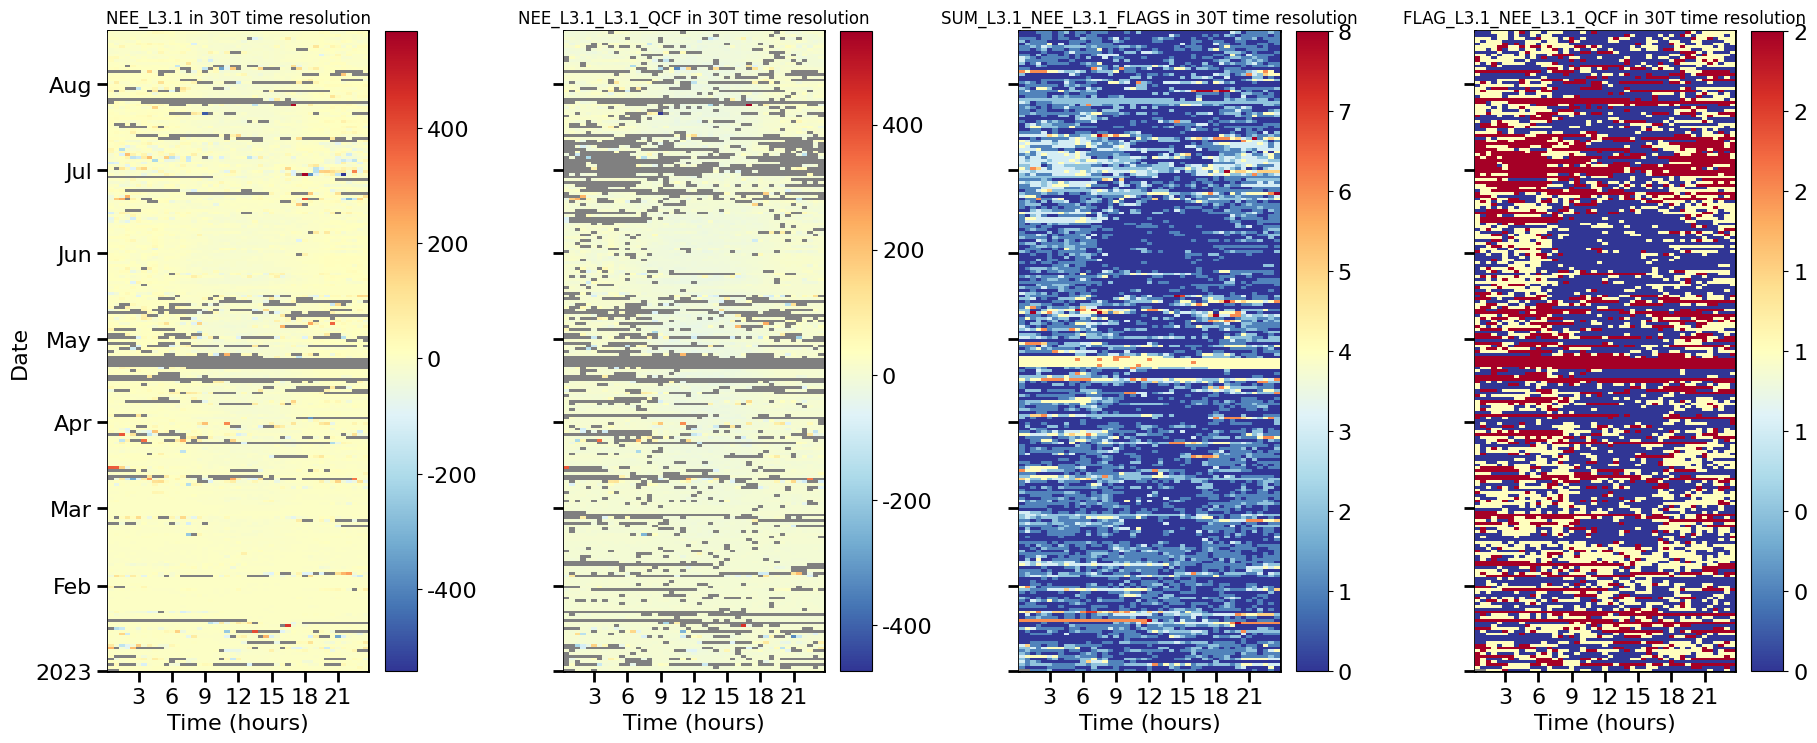

In [35]:
qcf.showplot_qcf_heatmaps()

In [36]:
qcf.report_qcf_series()



SUMMARY: FLAG_L3.1_NEE_L3.1_QCF, QCF FLAG FOR NEE_L3.1
Between 2023-01-01 01:15 and 2023-08-20 18:45 ...
    Total flux records BEFORE quality checks: 9917 (89.15% of potential)
    Available flux records AFTER quality checks: 8205 (82.74% of total)
    Rejected flux records: 1712 (17.26% of total)
    Potential flux records: 11124
    Potential flux records missed: 1207 (10.85% of potential)



In [ ]:
qcf.report_qcf_flags()

In [ ]:
qcf.showplot_qcf_timeseries()

## Available `Level-3.1` variables after preliminary QCF
- This shows all available Level-3.1 variables, also the ones created previously for other fluxes

In [37]:
_vars = [print(x) for x in df_level31.columns if 'L3.1' in x]
FLUXVAR31QCF = f"{FLUXVAR31}_L3.1_QCF"  # Quality-controlled flux after Level-3.1
print(f"\nName of the storage-corrected and quality-controlled flux variable after Level-3.1:  {FLUXVAR31QCF}  (this variable will be used in the following outlier detection)")

NEE_L3.1
SC_SINGLE_gfRF_L3.1
SUM_L3.1_NEE_L3.1_HARDFLAGS
SUM_L3.1_NEE_L3.1_SOFTFLAGS
SUM_L3.1_NEE_L3.1_FLAGS
FLAG_L3.1_NEE_L3.1_QCF
NEE_L3.1_L3.1_QCF

Name of the storage-corrected and quality-controlled flux variable after Level-3.1:  NEE_L3.1_L3.1_QCF  (this variable will be used in the following outlier detection)


</br>

</br>

---

# **Level-3.2: Outlier detection**
- Needs quality-controlled data (so far)

</br>

## Plot time series

In [38]:
print(f"{FLUXVAR31QCF} \n(quality-controlled Level-3.1 version of {FLUXVAR31}) \n(originally based on {FLUXVAR})")

NEE_L3.1_L3.1_QCF 
(quality-controlled Level-3.1 version of NEE_L3.1) 
(originally based on FC)


In [39]:
TimeSeries(series=df_level31[FLUXVAR31QCF]).plot_interactive()

</br>

## Initiate calculations

In [40]:
sod = StepwiseOutlierDetection(dataframe=df_level31,
                               col=FLUXVAR31QCF,
                               site_lat=SITE_LAT,
                               site_lon=SITE_LON,
                               timezone_of_timestamp='UTC+01:00')

</br>

</br>

## Flag, outlier detection: **absolute limits, separate for daytime and nighttime data**

Identify outliers based on absolute limits separately for daytime and nighttime


[AbsoluteLimitsDaytimeNighttime]  ========================================
[AbsoluteLimitsDaytimeNighttime]  AbsoluteLimitsDaytimeNighttime
[AbsoluteLimitsDaytimeNighttime]  ========================================
Generating flag FLAG_NEE_L3.1_L3.1_QCF_OUTLIER_ABSLIM_DTNT_TEST for variable NEE_L3.1_L3.1_QCF ...
Calculating sun altitude in 30T time resolution ...
Generating nighttime flag (1=nighttime, 0=daytime) from sun altitude ...
[AbsoluteLimitsDaytimeNighttime]  Done.
[AbsoluteLimitsDaytimeNighttime]  ________________________________________


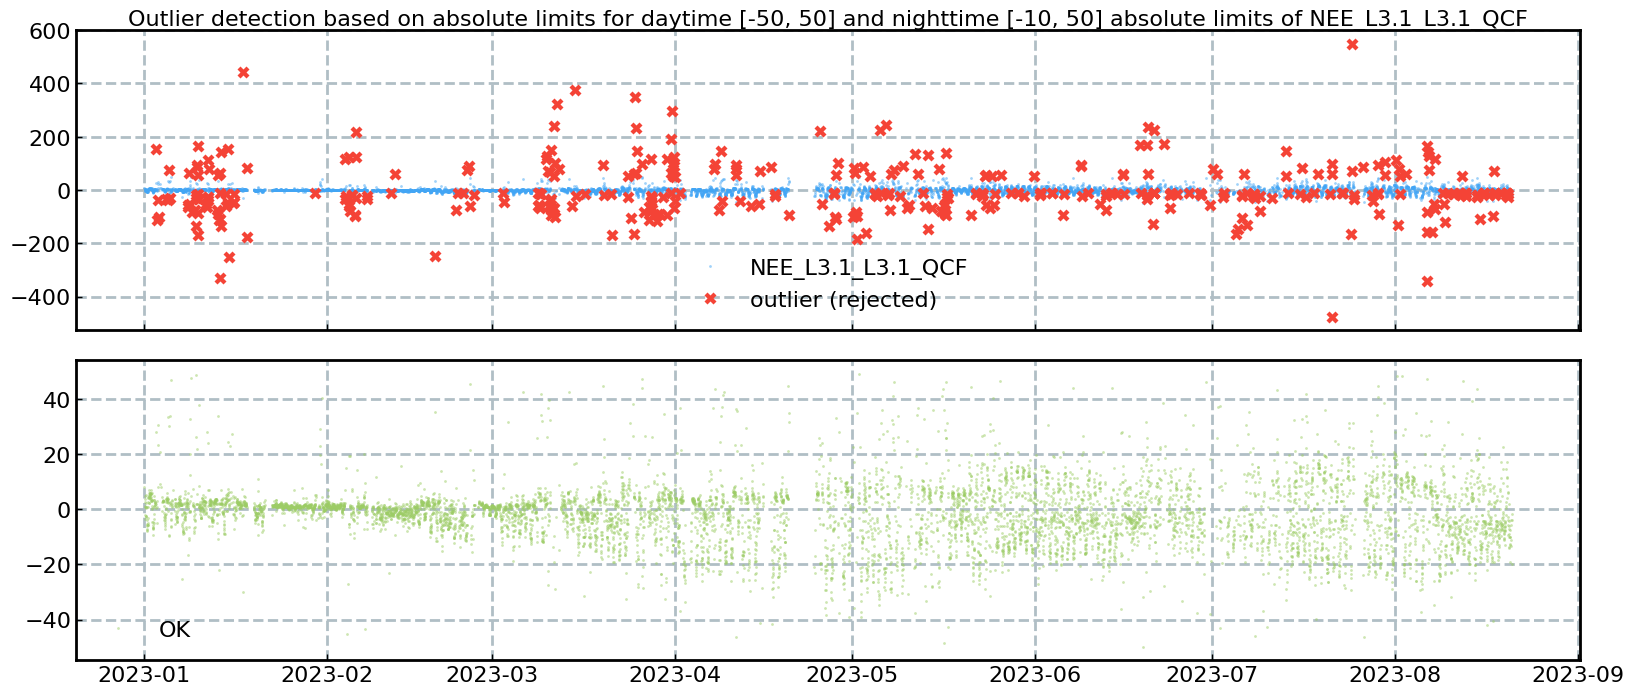

In [41]:
MIN_DT = -50
MAX_DT = 50
MIN_NT = -10
MAX_NT = 50
print(sod.flag_outliers_abslim_dtnt_test.__doc__)
sod.flag_outliers_abslim_dtnt_test(daytime_minmax=[MIN_DT, MAX_DT], nighttime_minmax=[MIN_NT, MAX_NT], showplot=True, verbose=True)

In [42]:
sod.addflag()

++Added flag column FLAG_NEE_L3.1_L3.1_QCF_OUTLIER_ABSLIM_DTNT_TEST to flag data


</br>

</br>

## Flag, outlier detection: **Absolute limits**

In [ ]:
MIN = -200
MAX = 1000
print(sod.flag_outliers_abslim_test.__doc__)
sod.flag_outliers_abslim_test(minval=MIN, maxval=MAX, showplot=True, verbose=True)

In [ ]:
sod.addflag()

</br>

</br>

## Flag, outlier detection: **z-score over all data, separate for daytime and nighttime**

Flag outliers based on z-score, calculated separately for daytime and nighttime


[zScoreDaytimeNighttime]  ========================================
[zScoreDaytimeNighttime]  zScoreDaytimeNighttime
[zScoreDaytimeNighttime]  ========================================
Generating flag FLAG_NEE_L3.1_L3.1_QCF_OUTLIER_ZSCOREDTNT_TEST for variable NEE_L3.1_L3.1_QCF ...
Calculating sun altitude in 30T time resolution ...
Generating nighttime flag (1=nighttime, 0=daytime) from sun altitude ...
[zScoreDaytimeNighttime]  Done.
[zScoreDaytimeNighttime]  ________________________________________
Total found outliers: 18 values (daytime)
Total found outliers: 34 values (nighttime)
Total found outliers: 52 values (daytime+nighttime)


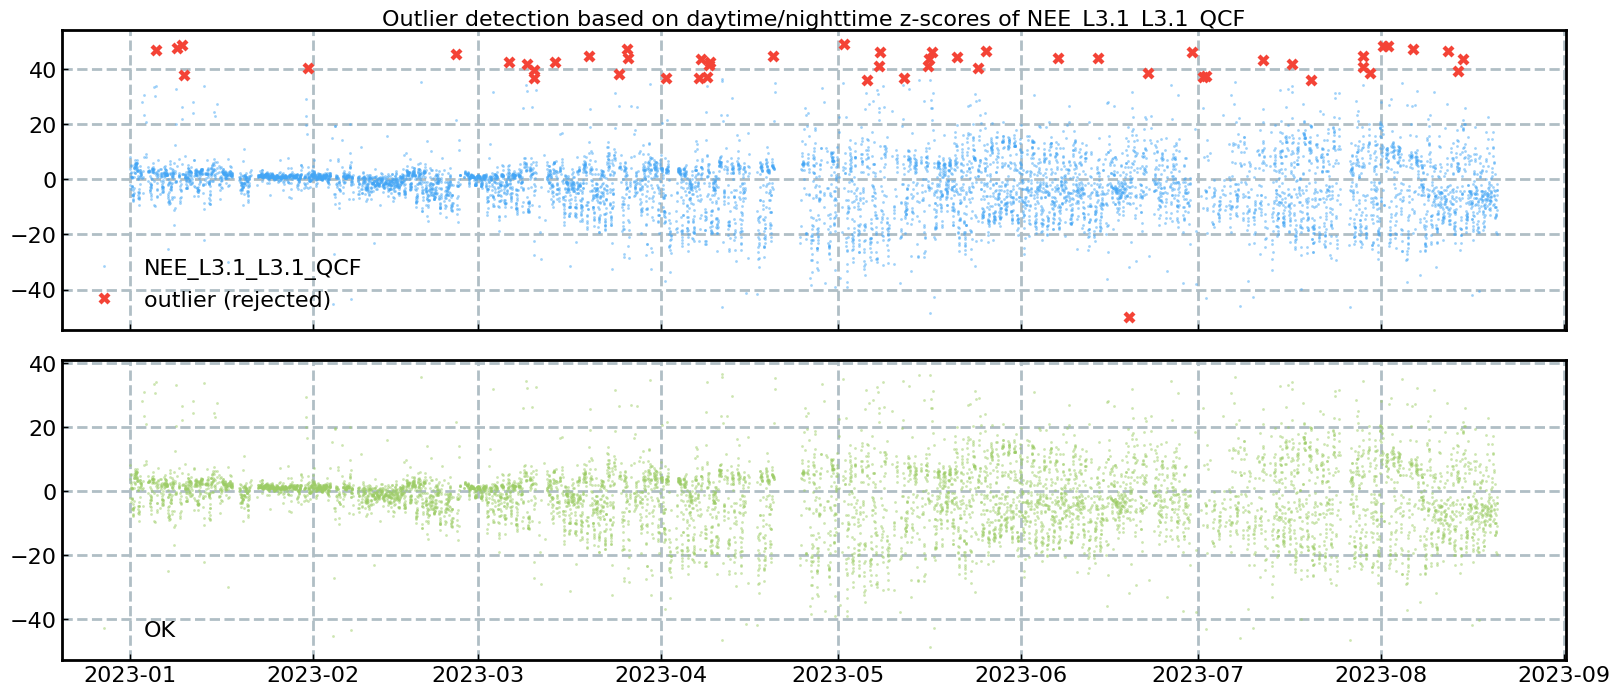

In [43]:
print(sod.flag_outliers_zscore_dtnt_test.__doc__)
sod.flag_outliers_zscore_dtnt_test(threshold=4, showplot=True, verbose=True)

In [44]:
sod.addflag()

++Added flag column FLAG_NEE_L3.1_L3.1_QCF_OUTLIER_ZSCOREDTNT_TEST to flag data


</br>

</br>

## Flag, oulier detection: **Local standard deviation**

Identify outliers based on standard deviation in a rolling window


[LocalSD]  ========================================
[LocalSD]  LocalSD
[LocalSD]  ========================================
Generating flag FLAG_NEE_L3.1_L3.1_QCF_OUTLIER_LOCALSD_TEST for variable NEE_L3.1_L3.1_QCF ...
[LocalSD]  Done.
[LocalSD]  ________________________________________


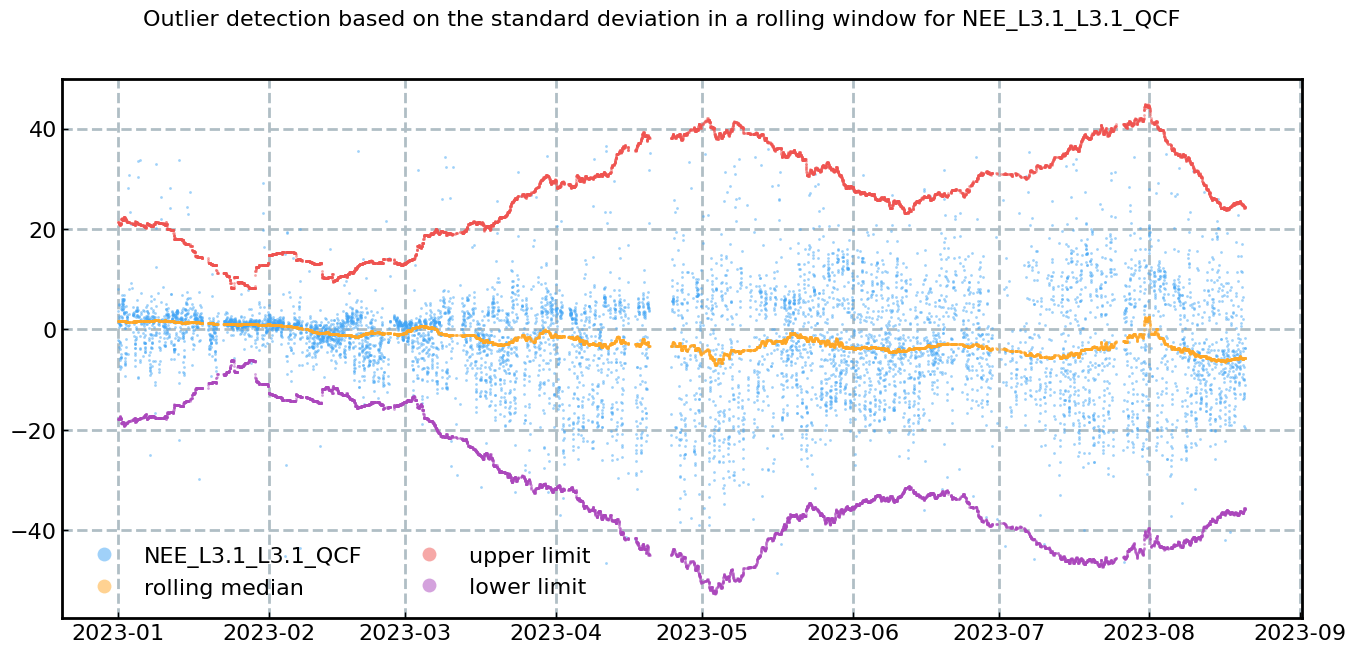

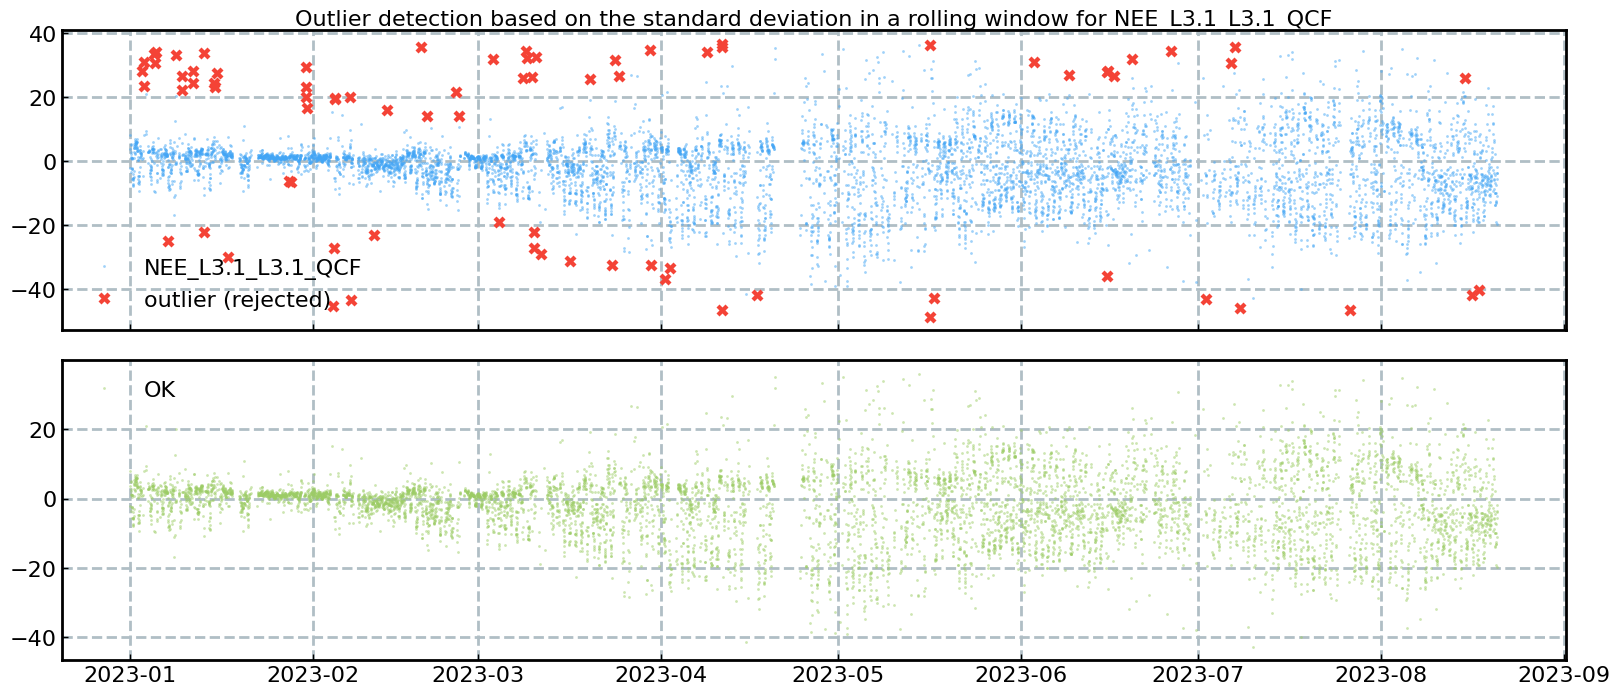

In [45]:
print(sod.flag_outliers_localsd_test.__doc__)
sod.flag_outliers_localsd_test(n_sd=3, winsize=480, showplot=True, verbose=True)

In [46]:
sod.addflag()

++Added flag column FLAG_NEE_L3.1_L3.1_QCF_OUTLIER_LOCALSD_TEST to flag data


</br>

</br>

## Flag, outlier detection: **Manual flagging of datapoints**

In [ ]:
print(sod.flag_manualremoval_test.__doc__)
sod.flag_manualremoval_test(remove_dates=[['2019-12-31 19:45:00', '2020-01-31 19:45:00']],
                            showplot=True, verbose=True)

In [ ]:
sod.addflag()

</br>

</br>

## Flag, outlier detection: **Increments z-score**

In [ ]:
print(sod.flag_outliers_increments_zcore_test.__doc__)
sod.flag_outliers_increments_zcore_test(threshold=10, showplot=True, verbose=True)

In [ ]:
sod.addflag()

</br>

</br>

## Flag, outlier detection: **z-score over all data with IQR**

In [ ]:
print(sod.flag_outliers_zscoreiqr_test.__doc__)
sod.flag_outliers_zscoreiqr_test(factor=2, showplot=True, verbose=True)

In [ ]:
sod.addflag()

</br>

</br>

## Flag, outlier detection: **z-score over all data**

In [ ]:
print(sod.flag_outliers_zscore_test.__doc__)
sod.flag_outliers_zscore_test(threshold=4, showplot=True, verbose=True)

In [ ]:
sod.addflag()

</br>

</br>

## Flag, outlier detection: **Seasonal trend decomposition with z-score on residuals**

In [ ]:
print(sod.flag_outliers_stl_rz_test.__doc__)
sod.flag_outliers_stl_rz_test(zfactor=3, decompose_downsampling_freq='6H', repeat=False, showplot=True)

In [ ]:
sod.showplot_orig()
sod.showplot_cleaned()

In [ ]:
sod.addflag()

</br>

</br>

## Flag, outlier detection: **Seasonsal trend decomposition with z-score on residuals (IQR)**

In [ ]:
print(sod.flag_outliers_stl_riqrz_test.__doc__)
sod.flag_outliers_stl_riqrz_test(zfactor=2, decompose_downsampling_freq='6H', repeat=False, showplot=True)

In [ ]:
sod.addflag()

</br>

</br>

## Flag, outlier detection: **Thymeboost**
- More info about [thymeboost](https://github.com/tblume1992/ThymeBoost)

In [ ]:
print(sod.flag_outliers_thymeboost_test.__doc__)
sod.flag_outliers_thymeboost_test(showplot=True, verbose=True)

In [ ]:
sod.addflag()

</br>

</br>

## Flag, outlier detection: **Local outlier factor**

In [ ]:
print(sod.flag_outliers_lof_test.__doc__)
sod.flag_outliers_lof_test(n_neighbors=None, contamination=0.005, showplot=True, verbose=True)

In [ ]:
sod.addflag()

</br>

</br>

## Flag, outlier detection: **Local outlier factor, daytime/nighttime**

In [ ]:
print(sod.flag_outliers_lof_dtnt_test.__doc__)
sod.flag_outliers_lof_dtnt_test(n_neighbors=None, contamination=0.0005, showplot=True, verbose=True)

In [ ]:
sod.addflag()

</br>

</br>

## Show outlier-cleaned flux

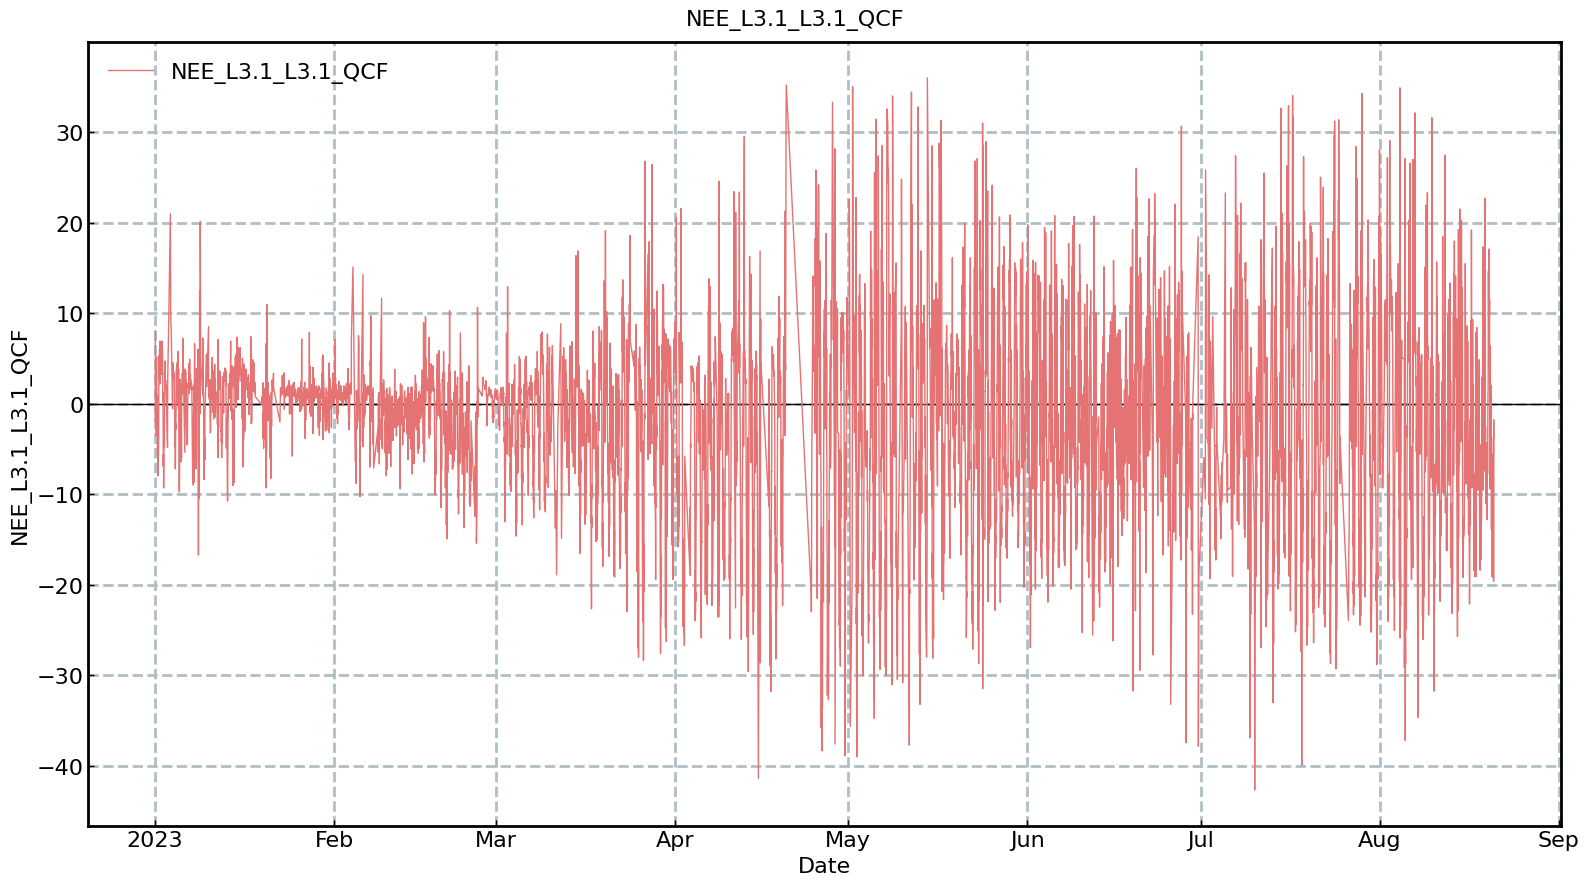

In [47]:
sod.showplot_cleaned()

</br>

</br>

## Finalize outlier detection: **Collect all flags**

In [48]:
df_level32 = sod.get()


Merging flags with full dataframe:
++Added flag column FLAG_NEE_L3.1_L3.1_QCF_OUTLIER_ABSLIM_DTNT_TEST as new column to full dataframe
++Added flag column FLAG_NEE_L3.1_L3.1_QCF_OUTLIER_ZSCOREDTNT_TEST as new column to full dataframe
++Added flag column FLAG_NEE_L3.1_L3.1_QCF_OUTLIER_LOCALSD_TEST as new column to full dataframe


</br>

## Generate `QCF`, needed for Level-3.3

In [49]:
qcf = FlagQCF(series=df_level32[FLUXVAR31], df=df_level32, levelid='L3.2', swinpot=df_level32['SW_IN_POT'], nighttime_threshold=50)
qcf.calculate(daytime_accept_qcf_below=2, nighttimetime_accept_qcf_below=2)
df_level32_qcf = qcf.get()

++Adding new column SUM_L3.2_NEE_L3.1_HARDFLAGS to main data ...
++Adding new column SUM_L3.2_NEE_L3.1_SOFTFLAGS to main data ...
++Adding new column SUM_L3.2_NEE_L3.1_FLAGS to main data ...
++Adding new column FLAG_L3.2_NEE_L3.1_QCF to main data ...
++Adding new column NEE_L3.1_L3.2_QCF to main data ...


In [50]:
qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable NEE_L3.1.

Number of NEE_L3.1 records before QC: 9917
+++ FLAG_L2_FC_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 9917 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FC_SSITC_TEST rejected 725 values (+7.31%)      TOTALS: flag 0: 5299 (53.43%) / flag 1: 3893 (39.26%) / flag 2: 725 (7.31%)
+++ FLAG_L2_FC_COMPLETENESS_TEST rejected 24 values (+0.24%)      TOTALS: flag 0: 5283 (53.27%) / flag 1: 3885 (39.18%) / flag 2: 749 (7.55%)
+++ FLAG_L2_FC_SCF_TEST rejected 40 values (+0.40%)      TOTALS: flag 0: 5186 (52.29%) / flag 1: 3942 (39.75%) / flag 2: 789 (7.96%)
+++ FLAG_L2_FC_SIGNAL_STRENGTH_TEST rejected 254 values (+2.56%)      TOTALS: flag 0: 5113 (51.56%) / flag 1: 3761 (37.92%) / flag 2: 1043 (10.52%)
+++ FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST rejected 95 values (+0.96%)      TOTALS: flag 0: 5057 (50.99%) / flag 1: 372

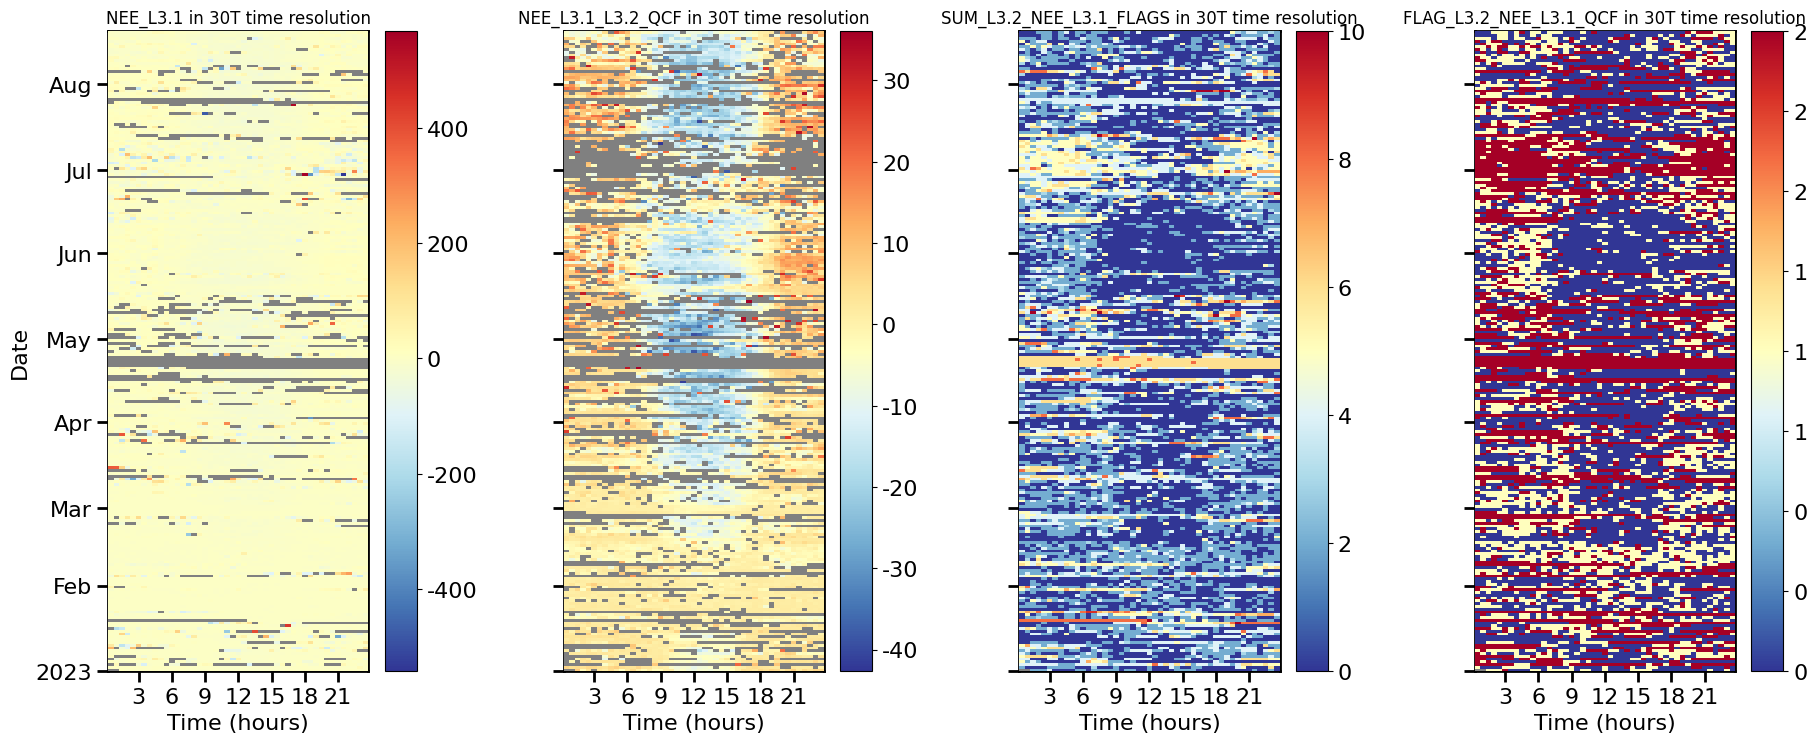

In [51]:
qcf.showplot_qcf_heatmaps()

In [52]:
qcf.report_qcf_series()



SUMMARY: FLAG_L3.2_NEE_L3.1_QCF, QCF FLAG FOR NEE_L3.1
Between 2023-01-01 01:15 and 2023-08-20 18:45 ...
    Total flux records BEFORE quality checks: 9917 (89.15% of potential)
    Available flux records AFTER quality checks: 7684 (77.48% of total)
    Rejected flux records: 2233 (22.52% of total)
    Potential flux records: 11124
    Potential flux records missed: 1207 (10.85% of potential)



In [ ]:
qcf.report_qcf_flags()

In [ ]:
qcf.showplot_qcf_timeseries()

</br>

## Available `Level-3.2` variables after preliminary QCF
- This shows all available Level-3.2 variables, also the ones created previously for other fluxes

In [53]:
_vars = [print(x) for x in df_level32_qcf.columns if 'L3.2' in x]
FLUXVAR32QCF = f"{FLUXVAR31}_L3.2_QCF"  # Quality-controlled flux after Level-3.2
print(f"\nName of the storage-corrected and quality-controlled flux variable after Level-3.2:  {FLUXVAR32QCF}")

SUM_L3.2_NEE_L3.1_HARDFLAGS
SUM_L3.2_NEE_L3.1_SOFTFLAGS
SUM_L3.2_NEE_L3.1_FLAGS
FLAG_L3.2_NEE_L3.1_QCF
NEE_L3.1_L3.2_QCF

Name of the storage-corrected and quality-controlled flux variable after Level-3.2:  NEE_L3.1_L3.2_QCF


</br>

## Plot quality-controlled flux after `Level-3.2`
- Plot flux after storage-correction, flux quality control and outlier removal

In [54]:
TimeSeries(series=df_level32_qcf[FLUXVAR32QCF]).plot_interactive()

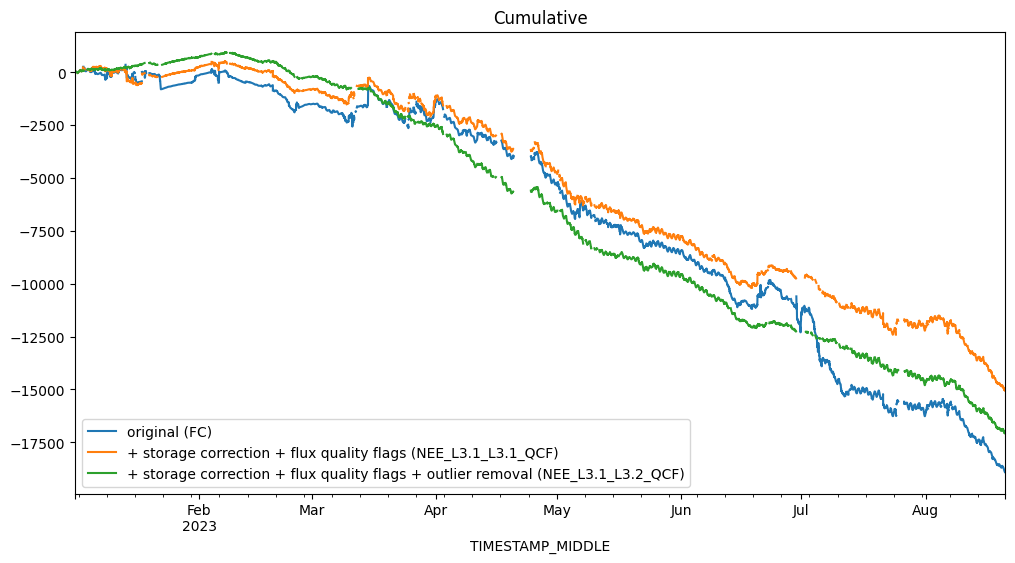

In [57]:
# Creating a dictionary by passing Series objects as values
frame = {
    f'original ({FLUXVAR})': df_level32_qcf[FLUXVAR],
    f'+ storage correction + flux quality flags ({FLUXVAR31QCF})': df_level32_qcf[FLUXVAR31QCF],    
    f'+ storage correction + flux quality flags + outlier removal ({FLUXVAR32QCF})': df_level32_qcf[FLUXVAR32QCF]
}

overview = pd.DataFrame(frame)
overview.cumsum().plot(title=f"Cumulative", figsize=(12, 6));

# **Overview after `Level-3.2`**

## Available `Level-3.2` fluxes

In [58]:
_fluxcols = [x for x in df_level32_qcf.columns if 'L3.1' and 'L3.2' in x and str(x).endswith('_QCF') and not str(x).startswith('FLAG_') ]
_fluxcols

['NEE_L3.1_L3.2_QCF']

In [59]:
_subset = df_level32_qcf[_fluxcols]
_subset

,NEE_L3.1_L3.2_QCF
TIMESTAMP_MIDDLE,
2023-01-01 01:15:00,7.990170
2023-01-01 01:45:00,-2.076858
2023-01-01 02:15:00,3.619622
2023-01-01 02:45:00,NaN
2023-01-01 03:15:00,2.689481
...,...
2023-08-20 16:45:00,-3.752027
2023-08-20 17:15:00,-19.642896
2023-08-20 17:45:00,-1.776301


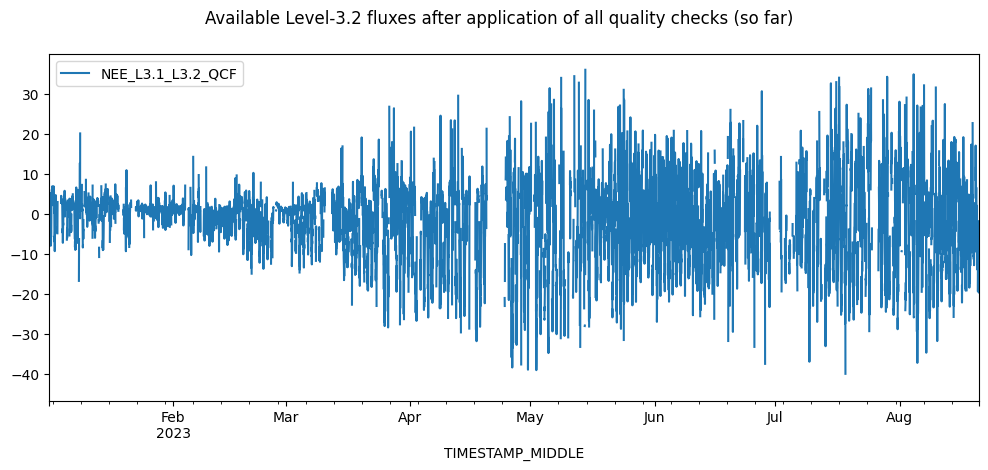

In [60]:
_subset.plot(subplots=True, title="Available Level-3.2 fluxes after application of all quality checks (so far)", figsize=(12, 4.5));

# **Save results to file**
- Save results to file for futher processing
- This can be useful if you want to use the data in another software, e.g. continuing post-processing using the library `ReddyProc` in `R` 
- `Parquet` format is recommended for large datasets

## Option 1: Save to CSV (large and slow)

In [ ]:
df_level32_qcf.to_csv("mylovelyhorse.csv")

## Option 2: Save to Parquet (small and fast)
- Needed if you want to continue post-processing in notebooks
- Can also be used in `R` with the `arrow` package

In [64]:
save_parquet(data=df_level32_qcf, filename="df_level32_qcf")

Saved file df_level32_qcf.parquet (0.239 seconds).


'df_level32_qcf.parquet'

# *(Preliminary) USTAR* (not for H2O fluxes `LE`, `ET` and `H2O`; not for sensible heat `H`)

## *(Preliminary) Impact of different USTAR thresholds on data availability*



[UstarThresholdConstantScenarios]  ========================================
[UstarThresholdConstantScenarios]  UstarThresholdConstantScenarios
[UstarThresholdConstantScenarios]  ========================================
[UstarThresholdConstantScenarios]  Done.
[UstarThresholdConstantScenarios]  ________________________________________


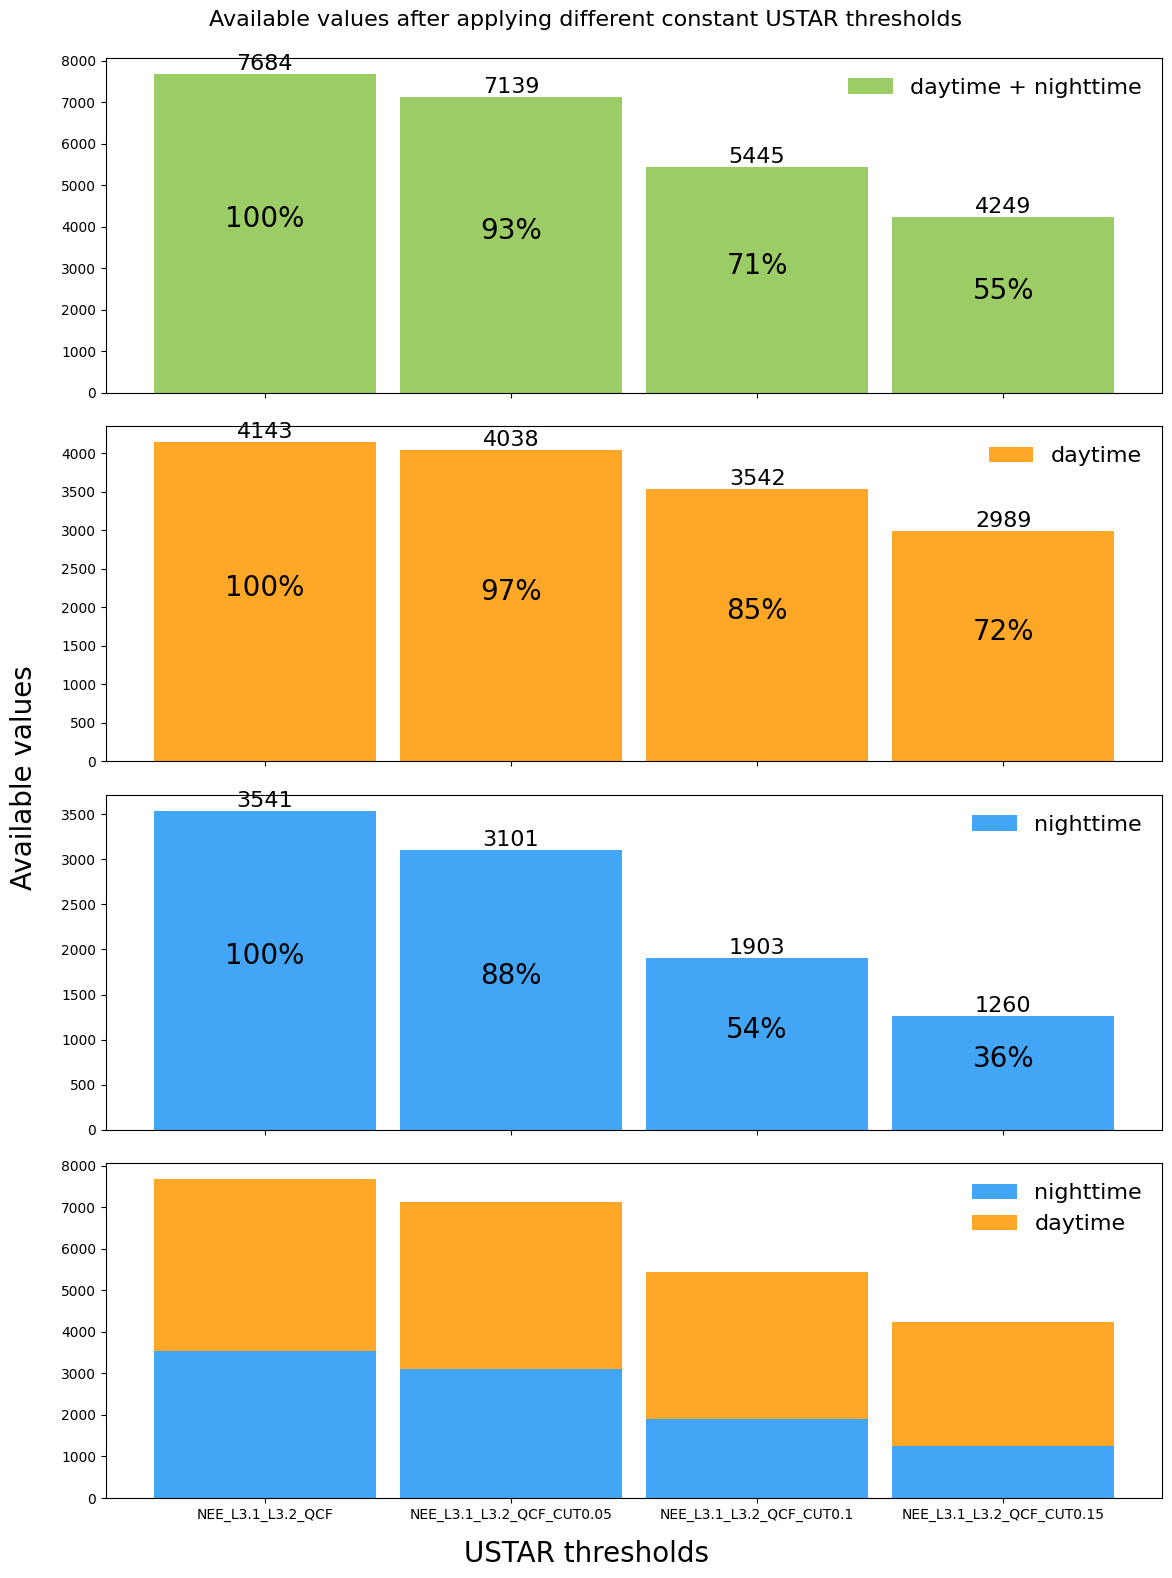

In [62]:
from diive.pkgs.flux.ustarthreshold import UstarThresholdConstantScenarios
ust = UstarThresholdConstantScenarios(series=df_level32_qcf[FLUXVAR32QCF],
                                      swinpot=df_level32_qcf['SW_IN_POT'],
                                      ustar=df_level32_qcf['USTAR'])
ust.calc(ustarthresholds=[0.05, 0.1, 0.15], showplot=True, verbose=True)

## *(Preliminary) Apply constant USTAR threshold*
- Use constant USTAR threshold for all data

(TODO)

# **FINISH**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [63]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2023-08-22 01:12:09
